# Predicting Pathogen from RNAseq data

## Create the model using hyperparameter tuning

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   34.4s finished


Best: -1.099814 using {'n_estimators': 1, 'max_depth': 1}
-1.099814 (0.011303) with: {'n_estimators': 1, 'max_depth': 1}
-1.112787 (0.029429) with: {'n_estimators': 3, 'max_depth': 1}
-1.135678 (0.042911) with: {'n_estimators': 5, 'max_depth': 1}
-1.165098 (0.052897) with: {'n_estimators': 7, 'max_depth': 1}
-1.198807 (0.060203) with: {'n_estimators': 9, 'max_depth': 1}
-1.099814 (0.011303) with: {'n_estimators': 1, 'max_depth': 3}
-1.112787 (0.029429) with: {'n_estimators': 3, 'max_depth': 3}
-1.135678 (0.042911) with: {'n_estimators': 5, 'max_depth': 3}
-1.165098 (0.052897) with: {'n_estimators': 7, 'max_depth': 3}
-1.198807 (0.060203) with: {'n_estimators': 9, 'max_depth': 3}
-1.099814 (0.011303) with: {'n_estimators': 1, 'max_depth': 5}
-1.112787 (0.029429) with: {'n_estimators': 3, 'max_depth': 5}
-1.135678 (0.042911) with: {'n_estimators': 5, 'max_depth': 5}
-1.165098 (0.052897) with: {'n_estimators': 7, 'max_depth': 5}
-1.198807 (0.060203) with: {'n_estimators': 9, 'max_depth': 

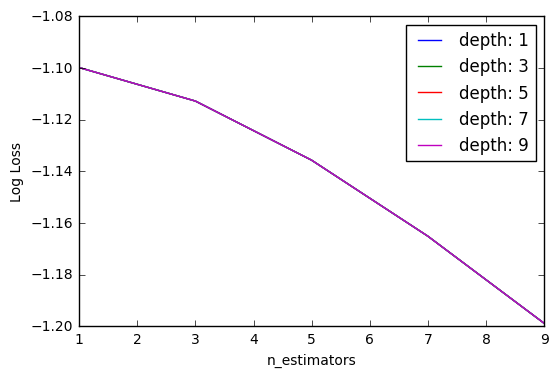

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

patient_groups=["control", "viral", "bacterial"]

X = pd.DataFrame.from_csv("combineSV_cutoff_WTcpmtable.txt", sep="\s+").T
y = [patient_groups.index("bacterial")] * 17 \
    + [patient_groups.index("viral")] * 13 \
    + [patient_groups.index("control")] * 18
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

model = XGBClassifier(objective="multi:softprob")
# Number of boosted trees to fit.
n_estimators = range(1, 11, 2)
# Maximum tree depth for base learners.
max_depth = range(1, 11, 2)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", 
                           n_jobs=1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
%matplotlib inline

scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')

## Make predictions based on the model

In [2]:
# make predictions
predicted = grid_result.predict(X_test)

print "Accuracy was %.2f%%\n" % (100 * accuracy_score(y_test, predicted))
print classification_report(y_test, predicted, target_names=patient_groups)
cm = confusion_matrix(y_test, predicted, labels=[0,1,2])
print "Confusion Matrix: rows = predictions, columns = actual\n"
row_format ="{:>15}" * (len(patient_groups)+1)
print row_format.format("", *patient_groups)
for disease, row in zip(patient_groups, cm):
    print row_format.format(disease, *row)

Accuracy was 60.00%

             precision    recall  f1-score   support

    control       1.00      0.22      0.36         9
      viral       0.57      0.80      0.67         5
  bacterial       0.55      1.00      0.71         6

avg / total       0.76      0.60      0.54        20

Confusion Matrix: rows = predictions, columns = actual

                       control          viral      bacterial
        control              2              3              4
          viral              0              4              1
      bacterial              0              0              6


## Review patients the model misclassified

In [3]:
probs = np.array(grid_result.predict_proba(X_test))
probs *= 100

d = {"Probability Control": probs[:, patient_groups.index("control")],
     "Probability Viral": probs[:, patient_groups.index("viral")],
     "Probability Bacterial": probs[:, patient_groups.index("bacterial")],
     "Predicted Class": [patient_groups[i] for i in grid_result.predict(X_test)],
     "Actual Class": [patient_groups[i] for i in y_test]}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df[patient_df["Predicted Class"] != patient_df["Actual Class"]]

,Actual Class,Predicted Class,Probability Bacterial,Probability Control,Probability Viral
MN_288,control,bacterial,64.981934,18.106680,16.911385
MN_368,control,bacterial,51.025547,35.695183,13.279269
MNC.036.y,control,viral,17.922520,26.526482,55.550999
MNC.118,control,bacterial,42.783756,18.473251,38.742989
MN_366,control,bacterial,50.911617,29.458258,19.630123
MN_386,control,viral,18.820522,19.826963,61.352516
MNC.354,control,viral,17.872032,23.867413,58.260559
MN_382,viral,bacterial,45.606640,39.644775,14.748590


In [4]:
from IPython.core.display import display, HTML

colname = "Importance"
df = pd.DataFrame(grid_result.best_estimator_.booster().get_score(importance_type="weight"),
                  index=[colname]).T
df = df[df[colname] > 0]
df = df.sort_values(by=[colname], ascending=False)

s="""
<h2>List of genes by importance</h2>
<p>Note: the NCBI link will open the target in a new window or tab.</p>
<table>
<tr><th>Gene</th><th>Importance</th><th>NCBI</th></tr>
"""

ncbi_url = lambda gene: "https://www.ncbi.nlm.nih.gov/gene/?term=%s[Gene Name] AND Human[Organism]" % (gene)

for index, row in df.iterrows():
    s += """
    <tr><td>%s</td><td>%d</td>
    <td><a target=\"_blank\" href=\"%s\">NCBI Search</a></td></tr>
    """ %(index, row[0], ncbi_url(index))
s += "</table>"

display(HTML(s))


Gene,Importance,NCBI
IL2RB,9,NCBI Search
FYN,9,NCBI Search
CISD3,7,NCBI Search
ACADL,5,NCBI Search
AAAS,2,NCBI Search
BBX,2,NCBI Search
SNRPD3,2,NCBI Search
ABCA5,2,NCBI Search
ACSL3,1,NCBI Search
ACTR1A,1,NCBI Search


In [5]:
# Dump booster info
print grid_result.best_estimator_.base_score
print "\n".join(grid_result.best_estimator_.booster().get_dump())

0.5
0:[CISD3<33.2943] yes=1,no=2,missing=1
	1:[AAK1<69.669] yes=3,no=4,missing=3
		3:leaf=-2.55448e-09
		4:leaf=-0.0657534
	2:leaf=0.1

0:[IL2RB<121.106] yes=1,no=2,missing=1
	1:leaf=-0.0670588
	2:leaf=0.1

0:[FYN<102.912] yes=1,no=2,missing=1
	1:[ACBD3<70.5997] yes=3,no=4,missing=3
		3:leaf=0.122449
		4:leaf=-2.55448e-09
	2:leaf=-0.0652174

0:[SNRPD3<63.2956] yes=1,no=2,missing=1
	1:[ABCA4<8.62762] yes=3,no=4,missing=3
		3:leaf=0.00153509
		4:leaf=-0.0641052
	2:leaf=0.0921011

0:[IL2RB<121.106] yes=1,no=2,missing=1
	1:leaf=-0.0648393
	2:leaf=0.0909845

0:[FYN<102.912] yes=1,no=2,missing=1
	1:[ACSL3<55.6768] yes=3,no=4,missing=3
		3:leaf=0.110487
		4:leaf=-0.00195514
	2:leaf=-0.0629057

0:[SNRPD3<63.2956] yes=1,no=2,missing=1
	1:[AGAP3<77.1361] yes=3,no=4,missing=3
		3:leaf=-0.0622751
		4:leaf=0.00305225
	2:leaf=0.0844542

0:[IL2RB<121.106] yes=1,no=2,missing=1
	1:leaf=-0.0627575
	2:leaf=0.083245

0:[FYN<102.912] yes=1,no=2,missing=1
	1:[ACTR1A<108.437] yes=3,no=4,missing=3
		3:leaf=0.

In [6]:
idf = X_test.loc[:, df.index.tolist()].copy()
idf["group"] = [patient_groups[idx] for idx in y_test]
idf

,IL2RB,FYN,CISD3,ACADL,AAAS,BBX,SNRPD3,ABCA5,ACSL3,ACTR1A,...,AAK1,AKAP2,ARID3A,ATP5I,ACBD3,BFAR,ABCA8,ABCA4,AGAP3,group
MNC.274,221.230426,529.029279,0.000000,0.000000,0.000000,0.000000,432.842138,0.000000,0.000000,0.000000,...,230.849140,0.0,0.000000,0.000000,0.000000,48.093571,0.000000,0.000000,0.000000,viral
MN_223,5.932641,51.416220,15.820375,0.000000,0.000000,98.877347,35.595845,3.955094,77.124330,27.685657,...,179.956771,0.0,37.573392,0.000000,189.844505,27.685657,0.000000,0.000000,9.887735,bacterial
MNC.073,545.341839,474.722033,0.000000,0.000000,0.000000,274.632581,70.619807,15.693290,66.696484,66.696484,...,337.405742,0.0,0.000000,0.000000,27.463258,98.083065,0.000000,11.769968,43.156548,viral
MN_288,0.000000,102.671321,0.000000,0.000000,0.000000,84.003808,37.335026,242.677668,0.000000,0.000000,...,308.013963,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.335026,control
MN_368,35.743008,65.528848,41.700176,0.000000,29.785840,214.458047,17.871504,77.443184,35.743008,0.000000,...,35.743008,0.0,0.000000,0.000000,47.657344,11.914336,113.186191,47.657344,41.700176,control
MNC.114,26.822955,187.760686,40.234433,0.000000,67.057388,40.234433,0.000000,0.000000,0.000000,227.995118,...,295.052506,0.0,26.822955,53.645910,0.000000,0.000000,53.645910,0.000000,120.703298,control
MNC.036.y,178.178255,362.720018,57.271582,44.544564,0.000000,241.813346,0.000000,57.271582,0.000000,114.543164,...,305.448436,0.0,38.181055,0.000000,12.727018,6.363509,95.452636,108.179655,50.908073,control
MNC.118,131.174864,69.445516,0.000000,7.716168,200.620380,208.336548,100.310190,69.445516,61.729348,30.864674,...,239.201222,0.0,92.594022,0.000000,38.580842,30.864674,108.026358,262.349728,100.310190,control
MN_286,15.959272,39.898180,23.938908,95.755632,0.000000,263.327987,95.755632,167.572355,215.450171,23.938908,...,103.735268,0.0,0.000000,0.000000,71.816724,15.959272,127.674176,63.837088,0.000000,bacterial
MN_363,79.277565,93.691668,28.828206,0.000000,43.242308,93.691668,14.414103,57.656411,86.484617,64.863462,...,237.832696,0.0,14.414103,7.207051,64.863462,28.828206,100.898719,201.797439,108.105771,bacterial
